# Online learning of AR(p) coefficients
$$p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1}, \mathbf{I}\gamma^{-1} \right)$$
where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix}
\end{align*}

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1186
┌ Info: Precompiling QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1186


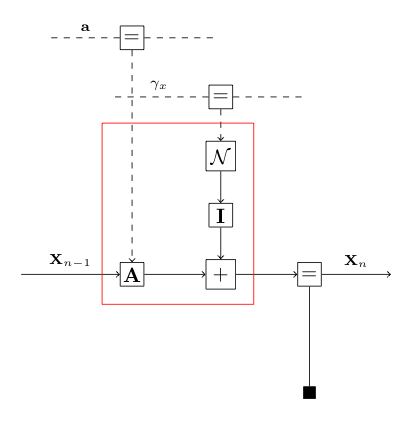

In [1]:
using Images
img = load("../ffgs/AR-online.png")

We are interested in a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma$

In [21]:
using ProgressMeter
using Revise
using ForneyLab
include("../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [25]:
ARorder = 10 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# Coefs and Observations
p_noise_var = 1.0
coefs, x = generate_data(1000, ARorder, 1, noise_variance=p_noise_var)

([-0.21984, 0.100983, -0.00889062, -0.204999, 0.0289466, 0.152255, -0.699689, -0.267148, 0.179456, 0.184912], Array{Float64,1}[[-1.82372, 1.6479, 4.27504, -1.28628, 0.403537, -1.18262, 1.16409, 0.860451, -0.792213, -2.7596], [-2.02783, -1.82372, 1.6479, 4.27504, -1.28628, 0.403537, -1.18262, 1.16409, 0.860451, -0.792213], [1.24448, -2.02783, -1.82372, 1.6479, 4.27504, -1.28628, 0.403537, -1.18262, 1.16409, 0.860451], [-0.78064, 1.24448, -2.02783, -1.82372, 1.6479, 4.27504, -1.28628, 0.403537, -1.18262, 1.16409], [1.95979, -0.78064, 1.24448, -2.02783, -1.82372, 1.6479, 4.27504, -1.28628, 0.403537, -1.18262], [-1.49795, 1.95979, -0.78064, 1.24448, -2.02783, -1.82372, 1.6479, 4.27504, -1.28628, 0.403537], [-2.28286, -1.49795, 1.95979, -0.78064, 1.24448, -2.02783, -1.82372, 1.6479, 4.27504, -1.28628], [2.04315, -2.28286, -1.49795, 1.95979, -0.78064, 1.24448, -2.02783, -1.82372, 1.6479, 4.27504], [2.49374, 2.04315, -2.28286, -1.49795, 1.95979, -0.78064, 1.24448, -2.02783, -1.82372, 1.6479],

In [26]:
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_x_t
@RV w_x_t
@RV a_w_t
@RV b_w_t
@RV m_a_t
@RV w_a_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(m_x_t, w_x_t)
@RV w ~ Gamma(a_w_t, b_w_t)
Autoregression(x_t, x_t_prev, a, w)

# Placeholders for prior
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_x_t, :m_x_t, dims=(ARorder,))
placeholder(w_x_t, :w_x_t, dims=(ARorder, ARorder))

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1299156548023787014 -->
 
 1299156548023787014 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 5684441983335510782 -->
 
 5684441983335510782 
 
 placeholder_m_x_t 
 
<!-- 15719350341563803652 -->
 
 15719350341563803652 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 5684441983335510782--15719350341563803652 -->
 
 5684441983335510782--15719350341563803652 
 
 m_x_t 
 2 m 
 1 out 
 
<!-- 12583226763229860050 -->
 
 12583226763229860050 
 
 Autoregression 
 autoregression_1 
 
<!-- 12583226763229860050--1299156548023787014 -->
 
 12583226763229860050--1299156548023787014 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 10323725232569213959 -->
 
 10323725232569213959 
 
 Gam 
 gamma_1 
 
<!-- 12583226763229860050--10323725232569213959 -->
 
 12583226763229860050--10323725232569213959 
 
 w 
 1 out 
 4 W 
 
<!-- 15464078043236097373 -->
 
 15464078043236097373 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 12583226763229860050--15464078043236097373 -->
 
 12583226763229860050--15464078043236097373 
 
 a 
 1 out 
 3 a 
 
<!-- 12583226763229860050--15719350341563803652 -->
 
 12583226763229860050--15719350341563803652 
 
 x_t 
 1 out 
 1 out 
 
<!-- 2446374953036783633 -->
 
 2446374953036783633 
 
 placeholder_a_w_t 
 
<!-- 2446374953036783633--10323725232569213959 -->
 
 2446374953036783633--10323725232569213959 
 
 a_w_t 
 2 a 
 1 out 
 
<!-- 1877984566444955650 -->
 
 1877984566444955650 
 
 placeholder_m_a_t 
 
<!-- 1877984566444955650--15464078043236097373 -->
 
 1877984566444955650--15464078043236097373 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 8619901292263632698 -->
 
 8619901292263632698 
 
 placeholder_w_x_t 
 
<!-- 8619901292263632698--15719350341563803652 -->
 
 8619901292263632698--15719350341563803652 
 
 w_x_t 
 3 w 
 1 out 
 
<!-- 9516506860708614493 -->
 
 9516506860708614493 
 
 placeholder_w_a_t 
 
<!-- 9516506860708614493--15464078043236097373 -->
 
 9516506860708614493--15464078043236097373 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 13582103824619297348 -->
 
 13582103824619297348 
 
 placeholder_b_w_t 
 
<!-- 13582103824619297348--10323725232569213959 -->
 
 13582103824619297348--10323725232569213959 
 
 b_w_t 
 3 b 
 1 out 
 
<!-- 12575928724799506188 -->
 
 12575928724799506188 
 
 placeholder_m_x_t_prev 
 
<!-- 12575928724799506188--1299156548023787014 -->
 
 12575928724799506188--1299156548023787014 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 3117831577590692021 -->
 
 3117831577590692021 
 
 placeholder_w_x_t_prev 
 
<!-- 3117831577590692021--1299156548023787014 -->
 
 3117831577590692021--1299156548023787014 
 
 w_x_t_prev 
 3 w 
 1 out

In [27]:
# Specify recognition factorization
q = RecognitionFactorization(a, w, ids=[:A, :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepW! (generic function with 3 methods)

In [32]:
# Define values for prior statistics
a_w_0 = 0.1
b_w_0 = 0.3
m_a_0 = -5.0 .+ zeros(ARorder)
w_a_0 = (tiny*diagAR(ARorder))

# First observations
m_x_prev_0 = x[1]
w_x_prev_0 = (huge*diagAR(ARorder))
m_x_0 = x[2]
w_x_0 = (huge*diagAR(ARorder));

In [33]:
# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(x))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(x))
m_x = Vector{Vector{Float64}}(undef, length(x))
w_x = Vector{Array{Float64, 2}}(undef, length(x))
a_w = Vector{Float64}(undef, length(x))
b_w = Vector{Float64}(undef, length(x))
m_a = Vector{Vector{Float64}}(undef, length(x))
w_a = Vector{Array{Float64, 2}}(undef, length(x))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_x_t_min = m_x_0
w_x_t_min = w_x_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [34]:
marginals = Dict()
n_its = 10
testSize = 20 # Number of points for test set
trainSize = length(x) - testSize
MSEs = []; # Storage for MSE for test set

# Storage for predictions
predictions = []
aCov = []
aMean = []
wVar = []
actual = [x[1] for x in x][trainSize:end];

In [35]:
p = Progress(trainSize, 1, "Observed ")
for t = 2:trainSize
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_min, w=w_x_t_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_x_t_min, w_x_t_min,
           a_w_t_min, b_w_t_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_a_t => m_a_t_min,
            :w_a_t => w_a_t_min,
            :m_x_t_prev => m_x_t_prev_min,
            :w_x_t_prev => w_x_t_prev_min,
            :m_x_t => m_x_t_min,
            :w_x_t => w_x_t_min,
            :a_w_t => a_w_t_min,
            :b_w_t => b_w_t_min)
        stepA!(data, marginals)
        stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = (huge*diagAR(ARorder))
        m_x_prev[t] = unsafeMean(marginals[:x_t_prev])
        w_x_prev[t] = (huge*diagAR(ARorder))
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = x[t]
        w_x_t_prev_min = w_x_prev[t]
        m_x_t_min = x[t+1]
        w_x_t_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    
    pred = [mean(marginals[:a])'x for x in x[trainSize-1:end-1]]
    push!(aMean, mean(marginals[:a]))
    push!(aCov, unsafeCov(marginals[:a]))
    push!(wVar, mean(marginals[:w]))
    push!(predictions, pred)
    push!(MSEs, mse(pred, actual))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:06


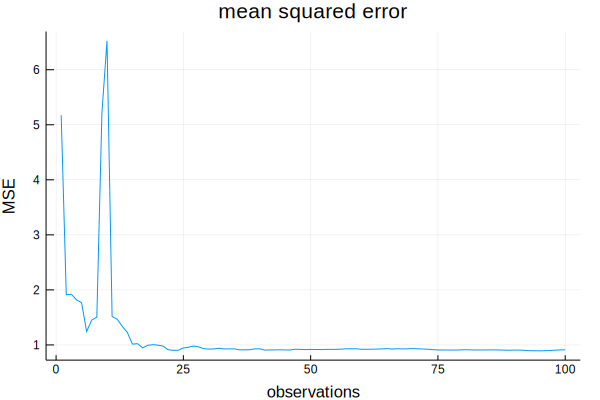

In [36]:
using Plots; theme(:default)
plot(MSEs[1:100], title="mean squared error", xlabel="observations", ylabel="MSE", legend=false)

In [37]:
# Plotting predictions
anim = @animate for i in 1:100:length(predictions)
    s = plot();
    ylims!(minimum(actual) - .1, maximum(actual) + .1);
    predicted = predictions[i]
    plot!(actual, title = "unforeseen data", xlabel="time", ylabel="value", label="actual")
    plot!(predicted, label="predicted")
end
gif(anim, "../gifs/AR-online.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif")

In [38]:
# Noise precision estimation
using Distributions
prior = Distributions.Gamma(a_w_0, 1/b_w_0)

anim = @animate for i in 1:100:length(a_w)
    s = plot();
    if a_w[i] <= 0 || b_w[i] <= 0
        continue
    end
    posterior = Distributions.Gamma(a_w[i], 1/b_w[i])
    plot!(pdf(prior,0:0.1:10), label="prior")
    plot!(pdf(posterior,0:0.1:10), label="posterior")
end
gif(anim, "../gifs/AR-gamma.gif", fps = 10)

┌ Warning: `pdf(d::UnivariateDistribution, X::AbstractArray)` is deprecated, use `pdf.(d, X)` instead.
│   caller = macro expansion at In[38]:11 [inlined]
└ @ Core ./In[38]:11
┌ Warning: `pdf(d::UnivariateDistribution, X::AbstractArray)` is deprecated, use `pdf.(d, X)` instead.
│   caller = macro expansion at In[38]:12 [inlined]
└ @ Core ./In[38]:12
┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-gamma.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-gamma.gif")

In [39]:
println("Δnoise(process, inferred)=", abs(p_noise_var - mean(marginals[:w])^-1))

Δnoise(process, inferred)=0.036120904544244437


In [40]:
# For plotting contours
using LinearAlgebra; 
 # use pyplot backend and define some defaults

len = 64

# Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) * exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ));

In [41]:
# !!! ONLY FOR AR(2)

# Plotting AR coefs
anim = @animate for i in 1:100:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    plot!([m_a_0[1]],[m_a_0[2]], seriestype=:scatter, title = "AR coefs", label="prior")
    plot!([coefs[1]],[coefs[2]], seriestype=:scatter, label="true")
    plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter, label="posterior")
    # get the maximum σ (used to construct the x and y ranges)
    σ_max = sqrt((w_a[i][1]^-1 > w_a[i][4]^-1 ) ? w_a[i][1]^-1 : w_a[i][4]^-1)

    rx = range(m_a[i][1]-3*σ_max, m_a[i][1]+3*σ_max, length=len)
    ry = range(m_a[i][2]-3*σ_max, m_a[i][2]+3*σ_max, length=len)
    contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], m_a[i], w_a[i]^-1), xlabel="a1", ylabel="a2")
end
gif(anim, "../gifs/AR-coefs.gif", fps = 10)

DimensionMismatch: DimensionMismatch("dimensions must match")

In [42]:
coefs

10-element Array{Float64,1}:
 -0.21983996266898148 
  0.1009829709432127  
 -0.008890619061086505
 -0.20499858949027044 
  0.028946605490908134
  0.1522552107831785  
 -0.6996887391239058  
 -0.2671479598606842  
  0.17945638828977928 
  0.1849119945327074  

In [44]:
mean(marginals[:w])^-1

0.9638790954557556

In [45]:
mean(marginals[:a])

10-element Array{Float64,1}:
 -0.2655096773890821  
  0.04168944148294518 
 -0.022775038670294567
 -0.20896290705793058 
  0.01944848427130319 
  0.14004166688338743 
 -0.6838656098790034  
 -0.3115351548487379  
  0.11375219370239587 
  0.12858413187425174 